In [1]:
import pandas as pd
data = pd.read_csv("./train.csv", sep=";")
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [2]:
#Merge column 'day' and 'month' to 'recency'
customers = data.copy()
import numpy as np
from EncodeDay import toRecency
customers['month'] = pd.to_datetime(customers['month'], format='%b').dt.month
customers['day'] = customers['month'].astype(str) + customers['day'].astype(str)
customers.drop('month', axis=1, inplace=True)
customers['day'] = customers['day'].astype(np.int64)
toRecent = toRecency(customers['day'], len(customers['day']))
customers['recency'] = toRecent
customers.drop('day', axis=1, inplace=True)
customers.head()


,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,recency
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,561
1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,561
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,561
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,561
4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,561


In [3]:
enc = {'yes':1, 'no':0}
customers['default'] = customers['default'].map(enc)
customers['housing'] = customers['housing'].map(enc)
customers['loan'] = customers['loan'].map(enc)
customers['y'] = customers['y'].map(enc)
customers.drop(['default', 'housing', 'loan', 'y'], axis=1, inplace=True)

In [4]:
customer_get_dummies = pd.get_dummies(customers[['job','marital','education','contact', 'poutcome']])
customers = customers.join(customer_get_dummies)
customers.drop(['job','marital','education','contact', 'poutcome'], axis=1, inplace=True)
customers.head()

,age,balance,duration,campaign,pdays,previous,recency,job_admin.,job_blue-collar,job_entrepreneur,...,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,261,1,-1,0,561,0,0,0,...,0,1,0,0,0,1,0,0,0,1
1,44,29,151,1,-1,0,561,0,0,0,...,1,0,0,0,0,1,0,0,0,1
2,33,2,76,1,-1,0,561,0,0,1,...,1,0,0,0,0,1,0,0,0,1
3,47,1506,92,1,-1,0,561,0,1,0,...,0,0,1,0,0,1,0,0,0,1
4,33,1,198,1,-1,0,561,0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
customers = scaler.fit_transform(customers)
customers = pd.DataFrame(customers)
customers.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.519481,0.092259,0.053070,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.337662,0.073067,0.030704,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.194805,0.072822,0.015453,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.376623,0.086476,0.018707,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.194805,0.072812,0.040260,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [6]:
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.initializers import glorot_uniform
from keras.optimizers import SGD

dim = 33
encoding_dim = 25

input_df = Input(shape=(dim,))


# Glorot normal initializer (Xavier normal initializer) draws samples from a truncated normal distribution 

x = Dense(encoding_dim, activation='relu')(input_df)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(x)

encoded = Dense(8, activation='tanh', kernel_initializer = 'glorot_uniform')(x)

x = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)

decoded = Dense(dim, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

#encoder - used for our dimention reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer= 'adam', loss='mean_squared_error')

In [7]:
customers.shape

(45211, 33)

In [8]:
autoencoder.fit(customers, customers, batch_size = 128, epochs = 2,  verbose = 1)

Epoch 1/2
354/354 [==============================] - 39s 109ms/step - loss: 0.0116
Epoch 2/2
354/354 [==============================] - 33s 94ms/step - loss: 6.5211e-04


In [9]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33)]              0         
                                                                 
 dense (Dense)               (None, 25)                850       
                                                                 
 dense_1 (Dense)             (None, 500)               13000     
                                                                 
 dense_2 (Dense)             (None, 500)               250500    
                                                                 
 dense_3 (Dense)             (None, 500)               250500    
                                                                 
 dense_4 (Dense)             (None, 2000)              1002000   
                                                                 
 dense_6 (Dense)             (None, 2000)              400200

In [10]:
autoencoder.save_weights('autoencoder.h5')

In [11]:
pred = encoder.predict(customers)

1413/1413 [==============================] - 5s 4ms/step


In [12]:
pred.shape

(45211, 8)

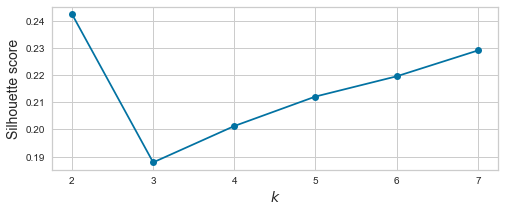

In [13]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

def lineSilhouetteScore(data, lower_, upper_):
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data) for k in range(lower_, upper_)]
    silhouette_scores = [silhouette_score(data, model.labels_) for model in kmeans_per_k]
    plt.figure(figsize=(8, 3))
    plt.plot(range(lower_, upper_), silhouette_scores, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Silhouette score", fontsize=14)
    plt.show()


def showSilhouetteScore(data, lower_, upper_):
    # silhouette_scores = []
    for n_clusters in range(lower_, upper_):
        model = KMeans(n_clusters, random_state=42)
        visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
        visualizer.fit(data)
        # visualizer.show()
        # silhouette_scores.append(visualizer.silhouette_score_)
        print("For n_clusters = {}, Kmeans silhouette score is {}".format(n_clusters, visualizer.silhouette_score_))
    # return silhouette_scores

import matplotlib.pyplot as plt

lineSilhouetteScore(pred, 2, 8)
# showSilhouetteScore(customers, 2, 8)

{2: 243.0960693359375,
 3: 210.36524963378906,
 4: 187.75755310058594,
 5: 168.75607299804688,
 6: 153.7825927734375,
 7: 144.0955810546875}

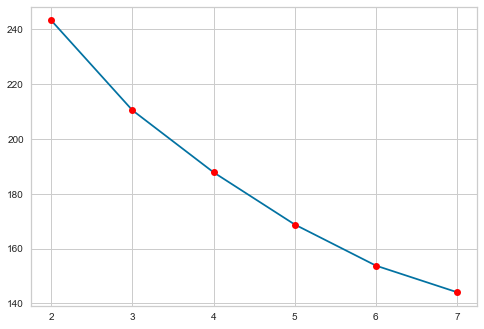

In [14]:
from matplotlib import markers
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def showElbow(data, lower_, upper_):
    sse = {}
    for k in range(lower_,upper_):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse[k] = kmeans.inertia_
    sse_keys = list(sse.keys())
    sse_values = list(sse.values())
    plt.plot(sse_keys, sse_values, marker='o', markerfacecolor='red')
    # plt.show()
    return sse

showElbow(pred, 2, 8)

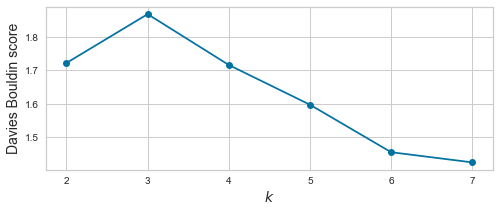

In [15]:
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def showDaviesBouldinScore(data, lower_, upper_):
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data) for k in range(lower_, upper_)]
    CH_scores = [davies_bouldin_score(data, model.labels_) for model in kmeans_per_k]
    plt.figure(figsize=(8, 3))
    plt.plot(range(lower_, upper_), CH_scores, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Davies Bouldin score", fontsize=14)
    plt.show()

showDaviesBouldinScore(pred, 2, 8)